In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install -qqq ftfy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

## for opening, manipulating, and saving many different image file f
from PIL import Image

import random 

## for plotting
import matplotlib.pyplot as plt

## for processing
import nltk
nltk.download('omw-1.4')
import re
import ftfy
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

#for expanding contracted words
import sys  
!{sys.executable} -m pip install contractions
import contractions

## WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud
from nltk import pos_tag ## For Parts of Speech tagging

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


SELECTING DATASETS

In [3]:
ds_all = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Eye_Under_Sampled.csv")
ds_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Virahonda.csv")
ds_test_kom = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Suicide_Detection_komati.csv")

In [4]:
print(ds_test_kom.head())

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [5]:
ds_test_kom=ds_test_kom.loc[ds_test_kom['class'] == 'suicide']
print(ds_test_kom.head())
ds_test_kom=ds_test_kom.sample(n = 50000,replace = False)
ds_test_kom.reset_index(inplace=True)

   Unnamed: 0                                               text    class
0           2  Ex Wife Threatening SuicideRecently I left my ...  suicide
3           8          i need helpjust help me im crying so hard  suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...  suicide
5          11  Honetly idkI dont know what im even doing here...  suicide
6          12  [Trigger warning] Excuse for self inflicted bu...  suicide


In [6]:
print("eye: ",ds_all.shape)
print("virahonda: ",ds_test.shape)
print("komati: ",ds_test_kom.shape)

eye:  (4628, 2)
virahonda:  (7145, 1)
komati:  (50000, 4)


In [7]:
print(ds_all.dtypes.to_frame().rename(columns={0:'data_type'}))

        data_type
message    object
label       int64


In [8]:
#ds_all.rename(columns = {'text':'message'}, inplace = True)

REMOVING UNWANTED COLOUMNS FROM DATASETS

In [9]:
# # required only for Eye dataset
# ds_all.drop(columns=['Unnamed: 0'], inplace=True)
ds_test['label'] = 1

In [10]:
#  old name - text, new - message
print(ds_all.isnull().sum().to_frame().rename(columns={0:'Null values'}))

         Null values
message            0
label              0


In [11]:
ds_test.rename(columns = {'Comments Text':'message'}, inplace = True)
print(ds_test.isnull().sum().to_frame().rename(columns={0:'Null values'}))

         Null values
message            0
label              0


In [12]:
ds_test_kom.drop(columns=['Unnamed: 0','class','index'], inplace=True)
ds_test_kom.rename(columns = {'text':'message'}, inplace = True)
ds_test_kom['label'] = 1
print(ds_test_kom.isnull().sum().to_frame().rename(columns={0:'Null values'}))

         Null values
message            0
label              0


DATASET NOISE CLEANING (PRE-PROCESSING)

In [13]:
def expandContracted(sentence):
  expanded_words = []   
  for word in sentence.split():
    # using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word))  
  res = ' '.join(expanded_words)
  return res

In [14]:
# LEMMATIZATION WITH POS TAG
# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
	if nltk_tag.startswith('J'):
		return wordnet.ADJ
	elif nltk_tag.startswith('V'):
		return wordnet.VERB
	elif nltk_tag.startswith('N'):
		return wordnet.NOUN
	elif nltk_tag.startswith('R'):
		return wordnet.ADV
	else:		
		return None

def lemmatize_func(text):
  lemmatizer = WordNetLemmatizer()
  # tokenize the sentence and find the POS tag for each token
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))

  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
    if tag is None:
      lemmatized_sentence.append(word)
    else:
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  lemmatized_sentence = " ".join(lemmatized_sentence)

  return lemmatized_sentence

In [15]:
# PRE-PROCESSING FUNCTION
def cleaning_process(input_tweets, input_labels):
  cleaned_tweets = []
  cleaned_labels = []
  for (a_tweet, a_label) in zip(input_tweets, input_labels):

    #convert to lowercase
    a_tweet = a_tweet.lower()
    
    # if url links then don't append to avoid news articles
    # also check tweet length, save those > 5 
    if re.match("(\w+:\/\/\S+)", a_tweet) == None and len(a_tweet) > 5:
      #remove @mention
      a_tweet = re.sub(r"(?:\@|https?\://)\S+", "", a_tweet)

      #remove punctuation
      a_tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", a_tweet).split())

      #remove hashtag, @mention, HTML tags and image URLs
      a_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<.>)|(pic\.twitter\.com\/.*)", " ", a_tweet).split())
      
      #remove numbers
      a_tweet = re.sub(r'\d+', '', a_tweet)

      #remove urls
      a_tweet = re.sub(r'https?://\S+|www\.\S+', '', a_tweet)

      #fix weirdly encoded texts (Unicode correction)
      a_tweet = ftfy.fix_text(a_tweet)

      #stop words
      stop_words = set(stopwords.words('english'))
      word_tokens = nltk.word_tokenize(a_tweet)
      a_tweet = [word for word in word_tokens if not word in stop_words]
      a_tweet = ' '.join(a_tweet) # join words with a space in between them

      #expand contraction
      a_tweet = expandContracted(a_tweet)

      #lemmatization
      a_tweet = lemmatize_func(a_tweet)

      #removing depression and diagnosis
      a_tweet = re.sub("depression",'', a_tweet)
      a_tweet = re.sub("diagnose", '', a_tweet)

      cleaned_tweets.append(a_tweet)
      cleaned_labels.append(a_label)
  return (cleaned_tweets, cleaned_labels)

CLEANING OF EYE DATASET

In [16]:
ds_text_all_arr = [x for x in ds_all['message']]
ds_label_all_arr = [x for x in ds_all['label']]
(cleaned_ds_text_all_arr, cleaned_ds_labels_all_arr) = cleaning_process(ds_text_all_arr, ds_label_all_arr)

CLEANING OF VIRAHONDA DATASET

In [17]:
ds_text_test_arr = [x for x in ds_test['message']]
ds_label_test_arr = [x for x in ds_test['label']]
(cleaned_ds_text_test_arr, cleaned_ds_labels_test_arr) = cleaning_process(ds_text_test_arr, ds_label_test_arr)

CLEANING OF KOMATI DATASET

In [18]:
ds_text_test_kom_arr = [x for x in ds_test_kom['message']]
ds_label_test_kom_arr = [x for x in ds_test_kom['label']]
(cleaned_ds_text_test_kom_arr, cleaned_ds_labels_test_kom_arr) = cleaning_process(ds_text_test_kom_arr, ds_label_test_kom_arr)

In [19]:
print(ds_text_all_arr[:10])

[' the oc http://mypict.me/1ord', 'getting my new car on monday  yay me !!', '@princess_narnia I heat!  I want a full shopping report, k? *squeee*', '@macster7 this a relief! Hahah. Telling my grievances to someone. Hahah. Thanks for absorbing. Hahah. Anyway, see you in school. ', 'Quick Question Is Fortune And Fame To Much To Ask For  Reply me &lt;3', 'oh boy my 1st text message of the day  my boy friend sent me a text yay ?', 'Aww @kynk  At least you only have 3 days of work this week ', "@kathyIreland Hugs 4 kathy. Though my mom's in heaven, I know she's smiling at my accomplishments &amp; all the people who keep me positive. ", 'Found out last night that an old friend had bike crash and has broken neck and internal bleeding  Giving nurses hell coz he wants a fag ', 'Resting from Rocking Space Jam with Atomic Babies- Udachi and us ']


In [20]:
print(cleaned_ds_text_all_arr[:10])

['oc', 'get new car monday yay', 'heat want full shopping report k squeee', 'relief hahah tell grievance someone hahah thanks absorb hahah anyway see school', 'quick question fortune fame much ask reply lt', 'oh boy st text message day boy friend send text yay', 'aww least day work week', 'hug kathy though mom heaven know smile accomplishment amp people keep positive', 'find last night old friend bike crash break neck internal bleeding give nurse hell coz want fag', 'rest rock space jam atomic baby udachi us']


WORD CLOUDS

In [21]:
ds_depressed = []
ds_notdepressed = []

for (text, label) in zip(cleaned_ds_text_all_arr, cleaned_ds_labels_all_arr):
  if label == 1:
    ds_depressed.append(text)
  else:
    ds_notdepressed.append(text)

In [22]:
str_depressed = ' '.join(ds_depressed)
str_notdepressed = ' '.join(ds_notdepressed)
str_vir = ' '.join(cleaned_ds_text_test_arr)
str_kom = ' '.join(cleaned_ds_text_test_kom_arr)

In [23]:
image = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Dataset/logo.jpeg'))

fig = plt.figure() # Instantiate the figure object
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

<Figure size 1400x1800 with 0 Axes>

In [24]:
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

WORD CLOUD FOR EYE DATASET DEPRESSED

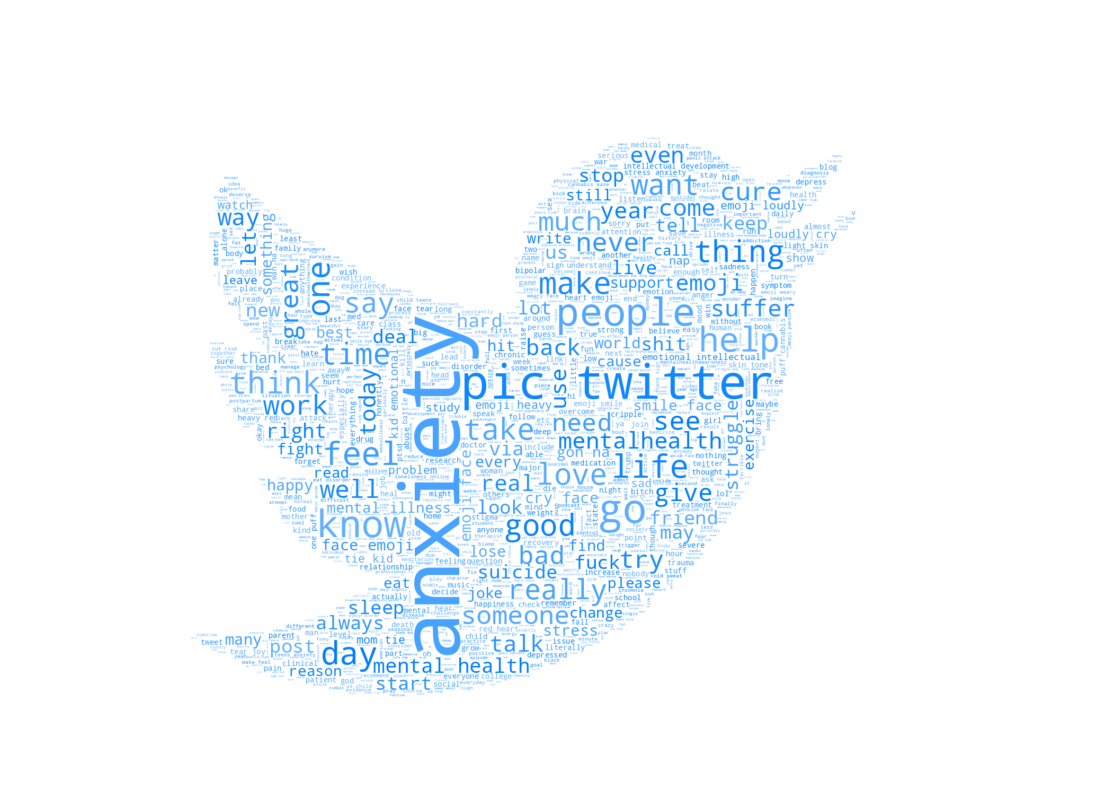

In [25]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_depressed)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR EYE DATASET NOT DEPRESSED

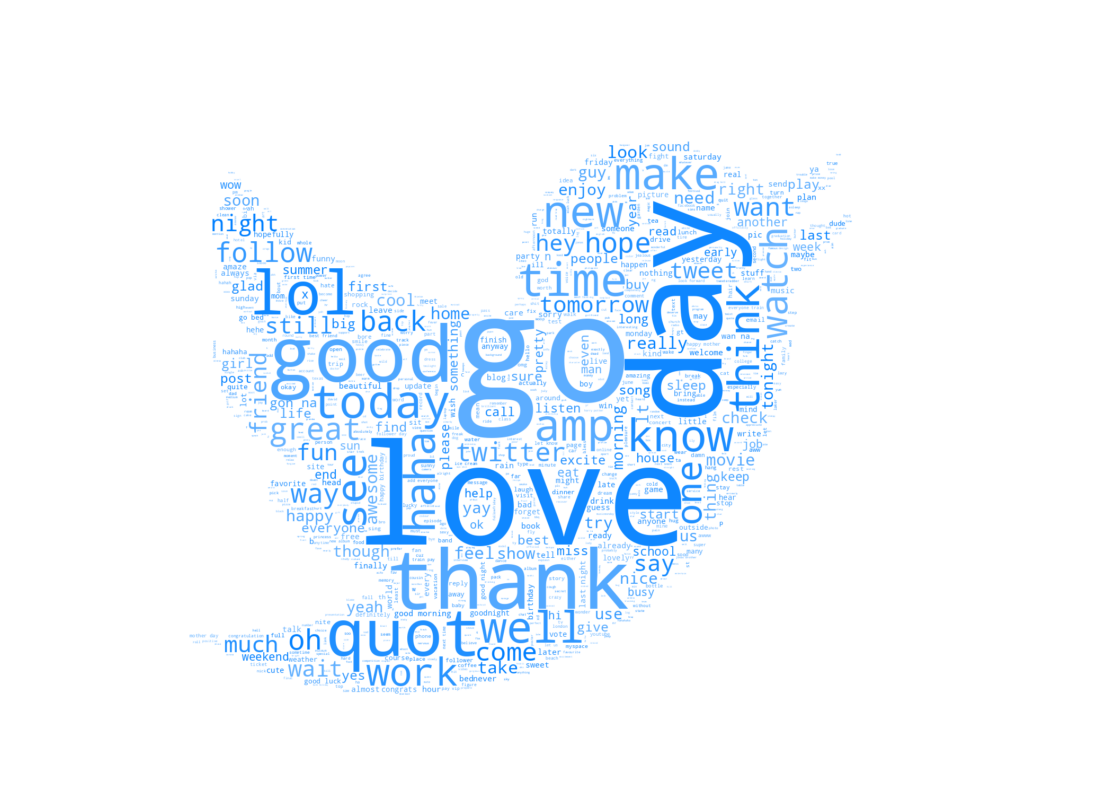

In [26]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_notdepressed)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR VIRAHONDA DATASET

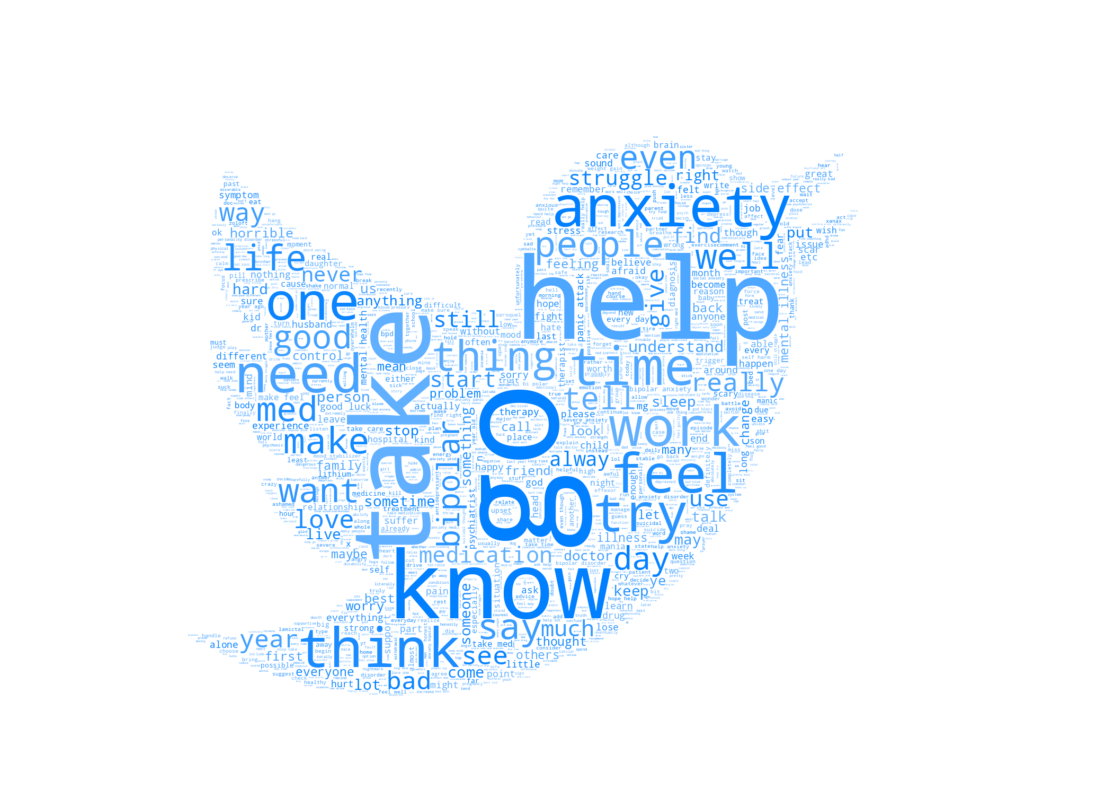

In [27]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_vir)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR KOMATI DATASET

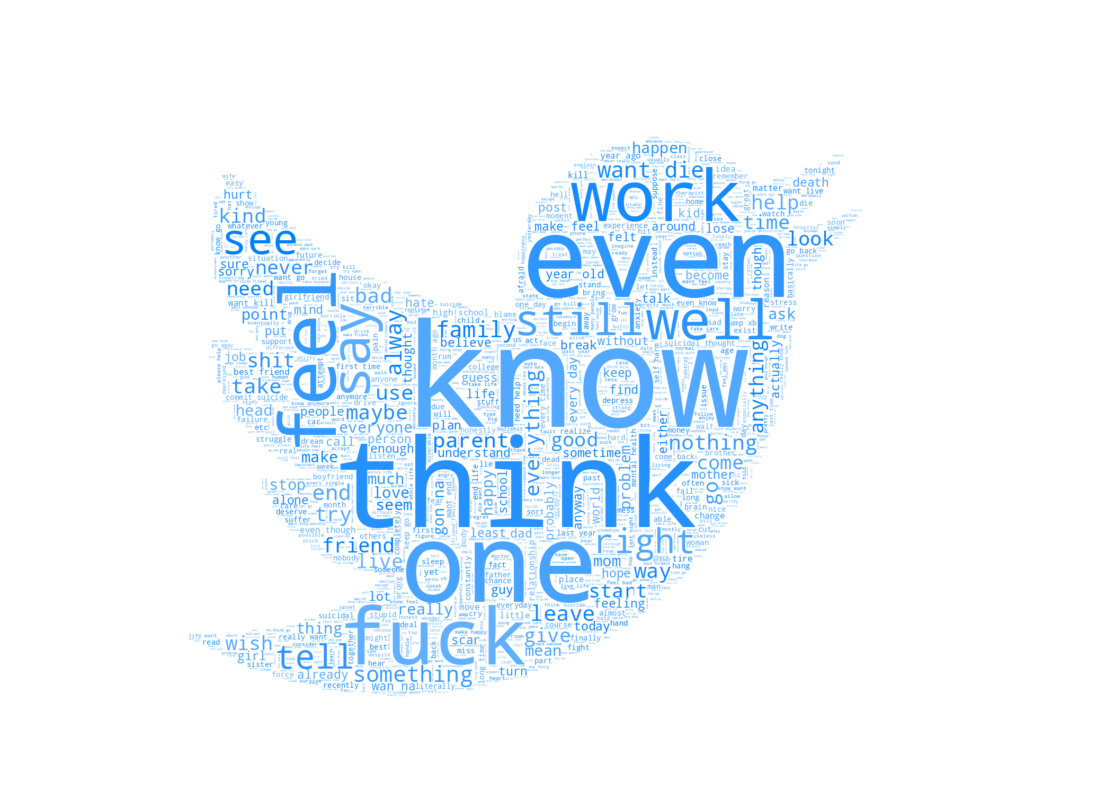

In [28]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_kom)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

BAG OF WORDS

In [29]:
from collections import Counter
from itertools import chain
from nltk.util import ngrams
from nltk.util import bigrams

def bow_for_line(corpus, top_words):
  bag_of_words = []
  for doc in corpus:
    unigram_words = doc
    bigram_words = list(bigrams(doc))
    trigram_words = list(ngrams(doc, 3))
    
    word_counts = Counter(doc)
    bigram_word_counts = Counter(bigram_words)
    trigram_word_counts = Counter(trigram_words)

    word_count=dict(word_counts)
    word_count.update(dict(bigram_word_counts))
    word_count.update(dict(trigram_word_counts))

    dict_words = dict(word_count)
    line_words = Counter(dict_words)

    row = [line_words[word] if word in line_words else 0 for word in top_words]
    bag_of_words.append(row)

  return bag_of_words

def bow(data_train):
  # Preprocess and tokenize the corpus
  corpus = [nltk.word_tokenize(doc.lower()) for doc in data_train]

  # Calculate the frequency of each word in the corpus
  word_counts = Counter(chain.from_iterable(corpus))

  bigram_words = []
  for doc in corpus:
    words = list(bigrams(doc))
    bigram_words.append(words)

  # Calculate the frequency of each bi and trigram words in the corpus
  bigram_word_counts = Counter(chain.from_iterable(bigram_words))

  trigram_words = []
  for doc in corpus:
    words = list(ngrams(doc, 3))
    trigram_words.append(words)

  trigram_word_counts = Counter(chain.from_iterable(trigram_words))

  word_count=dict(word_counts)
  word_count.update(dict(bigram_word_counts))
  word_count.update(dict(trigram_word_counts))

  word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
  dict_words = dict(word_count)
  final_words = Counter(dict_words)

  # # Select the top k most frequent words as columns
  top_words = [word for word, count in final_words.most_common(5000)]

  # # # Create the bag of words matrix
  bag_of_words = bow_for_line(corpus, top_words)
  
  return bag_of_words, top_words

BOW for EYE

In [30]:
bag_of_words, top_words = bow(cleaned_ds_text_all_arr)

print(len(bag_of_words[0]))
print(len(top_words))

5000
5000


In [31]:
column_words = []
for word in top_words:
  if isinstance(word, tuple):
    column_words.append(" ".join(word))
  else:
    column_words.append(word)

In [32]:
df = pd.DataFrame (bag_of_words, columns = column_words)
df.head()

,get,go,anxiety,emoji,twitter,like,com,pic,love,day,...,iron chef,good see,everyone go,put thing,cup coffee,take step,see movie,terminator salvation,make difference,sound much
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X = df
y = cleaned_ds_labels_all_arr
print(len(X), len(y))

4608 4608


BOW for VIRAHONDA

In [34]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in cleaned_ds_text_test_arr]

bag_of_words_test = bow_for_line(corpus, top_words)

In [35]:
test_df = pd.DataFrame (bag_of_words_test, columns = column_words)

In [36]:
test_df.head()

,get,go,anxiety,emoji,twitter,like,com,pic,love,day,...,iron chef,good see,everyone go,put thing,cup coffee,take step,see movie,terminator salvation,make difference,sound much
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,2,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,3,4,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X_vir = test_df
y_vir = cleaned_ds_labels_test_arr
len(X_vir), len(y_vir)

(7139, 7139)

BOW for KOMATI

In [38]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in cleaned_ds_text_test_kom_arr]

bag_of_words_test_kom = bow_for_line(corpus, top_words)

In [39]:
test_df_kom = pd.DataFrame (bag_of_words_test_kom, columns = column_words)

In [40]:
test_df_kom.head()

,get,go,anxiety,emoji,twitter,like,com,pic,love,day,...,iron chef,good see,everyone go,put thing,cup coffee,take step,see movie,terminator salvation,make difference,sound much
0,3,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X_kom = test_df_kom
y_kom = cleaned_ds_labels_test_kom_arr
len(X_kom), len(y_kom)

(49991, 49991)

BOW for EYE DEPRESSED

In [42]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in ds_depressed]

bag_of_words_test_dep = bow_for_line(corpus, top_words)

In [43]:
test_df_dep = pd.DataFrame (bag_of_words_test_dep, columns = column_words)

In [44]:
test_df_dep.head()

,get,go,anxiety,emoji,twitter,like,com,pic,love,day,...,iron chef,good see,everyone go,put thing,cup coffee,take step,see movie,terminator salvation,make difference,sound much
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X_dep = test_df_dep
y_dep=[]
for x in cleaned_ds_labels_all_arr:
  if x==1:
    y_dep.append(x)
len(X_dep), len(y_dep)

(2312, 2312)

BOW for EYE NOT DEPRESSED

In [46]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in ds_notdepressed]

bag_of_words_test_ndep = bow_for_line(corpus, top_words)

In [47]:
test_df_ndep = pd.DataFrame (bag_of_words_test_ndep, columns = column_words)

In [48]:
test_df_ndep.head()

,get,go,anxiety,emoji,twitter,like,com,pic,love,day,...,iron chef,good see,everyone go,put thing,cup coffee,take step,see movie,terminator salvation,make difference,sound much
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X_ndep = test_df_ndep
y_ndep=[]
for x in cleaned_ds_labels_all_arr:
  if x==0:
    y_ndep.append(x)
len(X_ndep), len(y_ndep)

(2296, 2296)

10 - FOLD CROSS VALIDATION FOR MODELS

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True)
splits=list(kf.split(X,y))
splits_test_vir=list(kf.split(X_vir,y_vir))
splits_test_kom=list(kf.split(X_kom,y_kom))
splits_test_dep=list(kf.split(X_dep,y_dep))
splits_test_ndep=list(kf.split(X_ndep,y_ndep))

LOGISTIC REGRESSION

In [51]:
LogReg_scores_eye = []
LogReg_scores_vir = []
LogReg_scores_kom = []
LogReg_scores_dep = []
LogReg_scores_ndep = []
LogReg_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_Log = LogisticRegression()
  model_Log.fit(X_train, y_train)
  y_pred = model_Log.predict(X_test)
  
  print("Fold - {} completed".format(k))

  #Eye testing
  LogReg_scores_eye.append(model_Log.score(X_test, y_test))
  y_pred_eye = model_Log.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  LogReg_scores_vir.append(model_Log.score(X_test_vir, y_test_vir))

  #Komati testing
  LogReg_scores_kom.append(model_Log.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  LogReg_scores_dep.append(model_Log.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  LogReg_scores_ndep.append(model_Log.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_eye)*100 + np.std(LogReg_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_vir)*100 + np.std(LogReg_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_kom)*100 + np.std(LogReg_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_dep)*100 + np.std(LogReg_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_ndep)*100 + np.std(LogReg_scores_ndep)*100))

LogReg_scores.append(np.mean(LogReg_scores_eye)*100 + np.std(LogReg_scores_eye)*100)
LogReg_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
LogReg_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
LogReg_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
LogReg_scores.append(np.mean(LogReg_scores_dep)*100 + np.std(LogReg_scores_dep)*100)
LogReg_scores.append(np.mean(LogReg_scores_ndep)*100 + np.std(LogReg_scores_ndep)*100)
LogReg_scores.append(np.mean(LogReg_scores_kom)*100 + np.std(LogReg_scores_kom)*100)
LogReg_scores.append(np.mean(LogReg_scores_vir)*100 + np.std(LogReg_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy LogReg: 87.7405
CV F1 score: 87.7151
CV Precision: 88.1412
CV Recall: 87.7613


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy LogReg: 90.0432


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy LogReg: 94.1167


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy LogReg: 94.0687


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy LogReg: 99.1837


LSVM

In [52]:
LSVM_scores_eye = []
LSVM_scores_vir = []
LSVM_scores_kom = []
LSVM_scores_dep = []
LSVM_scores_ndep = []
LSVM_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_LSVM = LinearSVC()
  model_LSVM.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  LSVM_scores_eye.append(model_LSVM.score(X_test, y_test))
  y_pred_eye = model_LSVM.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  LSVM_scores_vir.append(model_LSVM.score(X_test_vir, y_test_vir))

  #Komati testing
  LSVM_scores_kom.append(model_LSVM.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  LSVM_scores_dep.append(model_LSVM.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  LSVM_scores_ndep.append(model_LSVM.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_eye)*100 + np.std(LSVM_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_vir)*100 + np.std(LSVM_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_kom)*100 + np.std(LSVM_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_dep)*100 + np.std(LSVM_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_ndep)*100 + np.std(LSVM_scores_ndep)*100))

LSVM_scores.append(np.mean(LSVM_scores_eye)*100 + np.std(LSVM_scores_eye)*100)
LSVM_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
LSVM_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
LSVM_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
LSVM_scores.append(np.mean(LSVM_scores_dep)*100 + np.std(LSVM_scores_dep)*100)
LSVM_scores.append(np.mean(LSVM_scores_ndep)*100 + np.std(LSVM_scores_ndep)*100)
LSVM_scores.append(np.mean(LSVM_scores_kom)*100 + np.std(LSVM_scores_kom)*100)
LSVM_scores.append(np.mean(LSVM_scores_vir)*100 + np.std(LSVM_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy LSVM: 85.9712
CV F1 score: 85.9641
CV Precision: 86.0928
CV Recall: 85.9799


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy LSVM: 89.5274


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy LSVM: 91.8379


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy LSVM: 96.6078


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy LSVM: 99.4719


MLP

In [53]:
MLP_scores_eye = []
MLP_scores_vir = []
MLP_scores_kom = []
MLP_scores_dep = []
MLP_scores_ndep = []
MLP_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_MLP = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10)
  model_MLP.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  MLP_scores_eye.append(model_MLP.score(X_test, y_test))
  y_pred_eye = model_MLP.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  MLP_scores_vir.append(model_MLP.score(X_test_vir, y_test_vir))

  #Komati testing
  MLP_scores_kom.append(model_MLP.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  MLP_scores_dep.append(model_MLP.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  MLP_scores_ndep.append(model_MLP.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_eye)*100 + np.std(MLP_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_vir)*100 + np.std(MLP_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_kom)*100 + np.std(MLP_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_dep)*100 + np.std(MLP_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_ndep)*100 + np.std(MLP_scores_ndep)*100))

MLP_scores.append(np.mean(MLP_scores_eye)*100 + np.std(MLP_scores_eye)*100)
MLP_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
MLP_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
MLP_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
MLP_scores.append(np.mean(MLP_scores_dep)*100 + np.std(MLP_scores_dep)*100)
MLP_scores.append(np.mean(MLP_scores_ndep)*100 + np.std(MLP_scores_ndep)*100)
MLP_scores.append(np.mean(MLP_scores_kom)*100 + np.std(MLP_scores_kom)*100)
MLP_scores.append(np.mean(MLP_scores_vir)*100 + np.std(MLP_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy MLP: 88.3673
CV F1 score: 88.3672
CV Precision: 88.4151
CV Recall: 88.3745


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy MLP: 91.9410


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy MLP: 93.9821


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy MLP: 96.1048


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy MLP: 99.2666


DECISION TREE

In [54]:
DT_scores_eye = []
DT_scores_vir = []
DT_scores_kom = []
DT_scores_dep = []
DT_scores_ndep = []
DT_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_DT = DecisionTreeClassifier()
  model_DT.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  DT_scores_eye.append(model_DT.score(X_test, y_test))
  y_pred_eye = model_DT.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  DT_scores_vir.append(model_DT.score(X_test_vir, y_test_vir))

  #Komati testing
  DT_scores_kom.append(model_DT.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  DT_scores_dep.append(model_DT.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  DT_scores_ndep.append(model_DT.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_eye)*100 + np.std(DT_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_vir)*100 + np.std(DT_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_kom)*100 + np.std(DT_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_dep)*100 + np.std(DT_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_ndep)*100 + np.std(DT_scores_ndep)*100))

DT_scores.append(np.mean(DT_scores_eye)*100 + np.std(DT_scores_eye)*100)
DT_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
DT_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
DT_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
DT_scores.append(np.mean(DT_scores_dep)*100 + np.std(DT_scores_dep)*100)
DT_scores.append(np.mean(DT_scores_ndep)*100 + np.std(DT_scores_ndep)*100)
DT_scores.append(np.mean(DT_scores_kom)*100 + np.std(DT_scores_kom)*100)
DT_scores.append(np.mean(DT_scores_vir)*100 + np.std(DT_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy DT: 82.2613
CV F1 score: 82.2527
CV Precision: 82.3100
CV Recall: 82.2575


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy DT: 84.3067


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy DT: 75.2722


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy DT: 97.6320


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy DT: 98.6311


RESULT

In [55]:
LogReg_scores = [round(float(LogReg_scores[i]), 2) for i in range(0, len(LogReg_scores))]
LSVM_scores = [round(float(LSVM_scores[i]), 2) for i in range(0, len(LSVM_scores))]
MLP_scores = [round(float(MLP_scores[i]), 2) for i in range(0, len(MLP_scores))]
DT_scores = [round(float(DT_scores[i]), 2) for i in range(0, len(DT_scores))]

In [56]:
LogReg_scores.insert(0, "LR")
LSVM_scores.insert(0, "LSVM")
MLP_scores.insert(0, "MLP")
DT_scores.insert(0, "DT")

In [57]:
scores = []
scores.append(LogReg_scores)
scores.append(LSVM_scores)
scores.append(MLP_scores)
scores.append(DT_scores)

In [58]:
scores

[['LR', 87.74, 88.14, 87.76, 87.72, 94.07, 99.18, 94.12, 90.04],
 ['LSVM', 85.97, 86.09, 85.98, 85.96, 96.61, 99.47, 91.84, 89.53],
 ['MLP', 88.37, 88.42, 88.37, 88.37, 96.1, 99.27, 93.98, 91.94],
 ['DT', 82.26, 82.31, 82.26, 82.25, 97.63, 98.63, 75.27, 84.31]]

In [59]:
df = pd.DataFrame(scores, columns=['Classifier', 'Acc', 'Prec', 'Rec', 'F1', 'Dep', 'Non-Dep', 'Kom', 'Vir'])

In [60]:
df

,Classifier,Acc,Prec,Rec,F1,Dep,Non-Dep,Kom,Vir
0,LR,87.74,88.14,87.76,87.72,94.07,99.18,94.12,90.04
1,LSVM,85.97,86.09,85.98,85.96,96.61,99.47,91.84,89.53
2,MLP,88.37,88.42,88.37,88.37,96.10,99.27,93.98,91.94
3,DT,82.26,82.31,82.26,82.25,97.63,98.63,75.27,84.31


GRAPH PLOTTING

In [61]:
w=0.2
x = df['Classifier']
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]

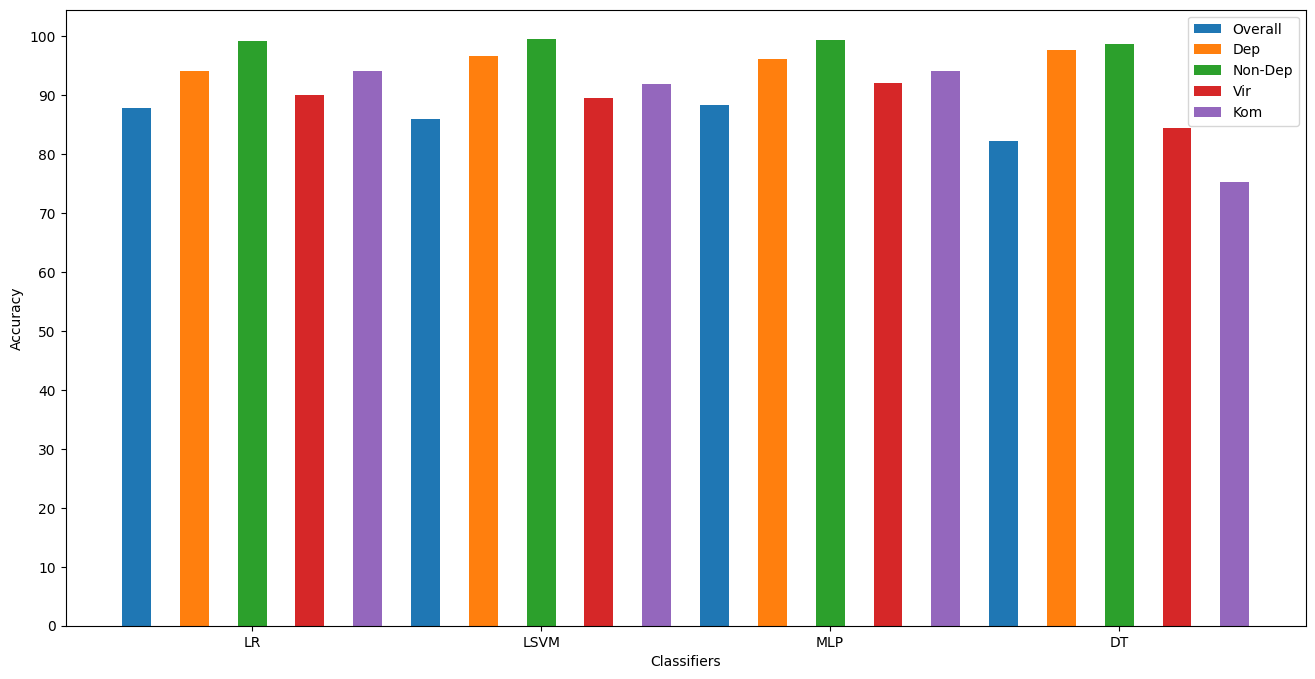

In [62]:
plt.figure(figsize=(16,8))
plt.bar(bar1, df['Acc'], label='Overall', align='edge', width=0.1)
plt.bar(bar2, df['Dep'], align='edge', width=0.1, label='Dep')
plt.bar(bar3, df['Non-Dep'], align='edge', width=0.1, label='Non-Dep')
plt.bar(bar4, df['Vir'], align='edge', width=0.1, label='Vir')
plt.bar(bar5, df['Kom'], align='edge', width=0.1, label='Kom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks(bar1+0.45, x)
plt.yticks(np.arange(0, 101, 10))
plt.legend(loc='upper right')
plt.show()

PLOTTING DECISION TREE

In [63]:
# X_dep = test_df_dep.iloc[:50, :10]
# X_notDep = test_df_ndep.iloc[:50, :10]
# X_tree = X_dep.append(X_notDep, ignore_index=True)
# X_tree.shape

In [64]:
# y_dep = [1 for i in range(0, 50)]
# y_notDep = [0 for i in range(0, 50)]
# y_tree = []
# y_tree.extend(y_dep)
# y_tree.extend(y_notDep)
# len(y_tree)

In [65]:
# X_tree.head()

In [66]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn import tree
# from sklearn import metrics

In [67]:
# X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y_tree, test_size=0.3) # 70% training and 30% test
# model = DecisionTreeClassifier(criterion="gini",max_depth=8)
# model.fit(X_tree_train, y_tree_train)

In [68]:
# fig = plt.figure(figsize=(25,20))
# figPlt = tree.plot_tree(model, feature_names=column_words[:10], class_names=["ndep", "dep"], filled=True)

In [69]:
# y_pred_tree = model.predict(X_tree_test)

In [70]:
# print("Accuracy:",metrics.accuracy_score(y_tree_test, y_pred_tree))

In [71]:
# model1 = DecisionTreeClassifier(criterion="entropy",max_depth=8)
# model1.fit(X_tree_train, y_tree_train)

In [72]:
# fig = plt.figure(figsize=(25,20))
# figPlt = tree.plot_tree(model1, feature_names=column_words[:10], class_names=["ndep", "dep"], filled=True)

In [73]:
# y_pred_tree1 = model1.predict(X_tree_test)

In [74]:
# print("Accuracy:",metrics.accuracy_score(y_tree_test, y_pred_tree1))

ENSEMBLE CLASSIFIERS

Adaptive Boosting

In [75]:
from sklearn.ensemble import AdaBoostClassifier
AB_scores_eye = []
AB_scores_vir = []
AB_scores_kom = []
AB_scores_dep = []
AB_scores_ndep = []
AB_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_AB = AdaBoostClassifier()
  model_AB.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  AB_scores_eye.append(model_AB.score(X_test, y_test))
  y_pred_eye = model_AB.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  AB_scores_vir.append(model_AB.score(X_test_vir, y_test_vir))

  #Komati testing
  AB_scores_kom.append(model_AB.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  AB_scores_dep.append(model_AB.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  AB_scores_ndep.append(model_AB.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_eye)*100 + np.std(AB_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_vir)*100 + np.std(AB_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_kom)*100 + np.std(AB_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_dep)*100 + np.std(AB_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_ndep)*100 + np.std(AB_scores_ndep)*100))

AB_scores.append(np.mean(AB_scores_eye)*100 + np.std(AB_scores_eye)*100)
AB_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
AB_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
AB_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
AB_scores.append(np.mean(AB_scores_dep)*100 + np.std(AB_scores_dep)*100)
AB_scores.append(np.mean(AB_scores_ndep)*100 + np.std(AB_scores_ndep)*100)
AB_scores.append(np.mean(AB_scores_kom)*100 + np.std(AB_scores_kom)*100)
AB_scores.append(np.mean(AB_scores_vir)*100 + np.std(AB_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy AB: 80.1426
CV F1 score: 79.7557
CV Precision: 82.8517
CV Recall: 80.2006


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy AB: 80.6281


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy AB: 85.5464


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy AB: 70.7195


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy AB: 96.5184


In [76]:
from sklearn.ensemble import BaggingClassifier
Bag_scores_eye = []
Bag_scores_vir = []
Bag_scores_kom = []
Bag_scores_dep = []
Bag_scores_ndep = []
Bag_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_Bag = BaggingClassifier()
  model_Bag.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  Bag_scores_eye.append(model_Bag.score(X_test, y_test))
  y_pred_eye = model_Bag.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  Bag_scores_vir.append(model_Bag.score(X_test_vir, y_test_vir))

  #Komati testing
  Bag_scores_kom.append(model_Bag.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  Bag_scores_dep.append(model_Bag.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  Bag_scores_ndep.append(model_Bag.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_eye)*100 + np.std(Bag_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_vir)*100 + np.std(Bag_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_kom)*100 + np.std(Bag_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_dep)*100 + np.std(Bag_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_ndep)*100 + np.std(Bag_scores_ndep)*100))

Bag_scores.append(np.mean(Bag_scores_eye)*100 + np.std(Bag_scores_eye)*100)
Bag_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
Bag_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
Bag_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
Bag_scores.append(np.mean(Bag_scores_dep)*100 + np.std(Bag_scores_dep)*100)
Bag_scores.append(np.mean(Bag_scores_ndep)*100 + np.std(Bag_scores_ndep)*100)
Bag_scores.append(np.mean(Bag_scores_kom)*100 + np.std(Bag_scores_kom)*100)
Bag_scores.append(np.mean(Bag_scores_vir)*100 + np.std(Bag_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy BP: 83.4141
CV F1 score: 83.3895
CV Precision: 83.5996
CV Recall: 83.4113


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy BP: 88.3695


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy BP: 82.8533


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy BP: 96.4348


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy BP: 98.9247


RANDOM FOREST

In [77]:
from sklearn.ensemble import RandomForestClassifier
RF_scores_eye = []
RF_scores_vir = []
RF_scores_kom = []
RF_scores_dep = []
RF_scores_ndep = []
RF_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_RF = RandomForestClassifier()
  model_RF.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  RF_scores_eye.append(model_RF.score(X_test, y_test))
  y_pred_eye = model_RF.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  RF_scores_vir.append(model_RF.score(X_test_vir, y_test_vir))

  #Komati testing
  RF_scores_kom.append(model_RF.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  RF_scores_dep.append(model_RF.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  RF_scores_ndep.append(model_RF.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_eye)*100 + np.std(RF_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_vir)*100 + np.std(RF_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_kom)*100 + np.std(RF_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_dep)*100 + np.std(RF_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_ndep)*100 + np.std(RF_scores_ndep)*100))

RF_scores.append(np.mean(RF_scores_eye)*100 + np.std(RF_scores_eye)*100)
RF_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
RF_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
RF_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
RF_scores.append(np.mean(RF_scores_dep)*100 + np.std(RF_scores_dep)*100)
RF_scores.append(np.mean(RF_scores_ndep)*100 + np.std(RF_scores_ndep)*100)
RF_scores.append(np.mean(RF_scores_kom)*100 + np.std(RF_scores_kom)*100)
RF_scores.append(np.mean(RF_scores_vir)*100 + np.std(RF_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy RF: 86.0091
CV F1 score: 85.9961
CV Precision: 86.1548
CV Recall: 86.0177


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy RF: 90.1583


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy RF: 93.7271


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy RF: 97.6813


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy RF: 99.5188


In [78]:
from sklearn.ensemble import GradientBoostingClassifier
GB_scores_eye = []
GB_scores_vir = []
GB_scores_kom = []
GB_scores_dep = []
GB_scores_ndep = []
GB_scores = []

f1_scores_eye = []
precision_scores_eye = []
recall_scores_eye = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_GB = GradientBoostingClassifier(learning_rate=0.1)
  model_GB.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Eye testing
  GB_scores_eye.append(model_GB.score(X_test, y_test))
  y_pred_eye = model_GB.predict(X_test)
  f1_scores_eye.append(f1_score(y_test, y_pred_eye, average='macro'))
  precision_scores_eye.append(precision_score(y_test, y_pred_eye, average='macro'))
  recall_scores_eye.append(recall_score(y_test, y_pred_eye, average='macro'))

  #Virahonda testing
  GB_scores_vir.append(model_GB.score(X_test_vir, y_test_vir))

  #Komati testing
  GB_scores_kom.append(model_GB.score(X_test_kom, y_test_kom))

  #EYE depressed only testing
  GB_scores_dep.append(model_GB.score(X_test_dep, y_test_dep))

  #EYE not depressed only testing
  GB_scores_ndep.append(model_GB.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with EYE dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_eye)*100 + np.std(GB_scores_eye)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_vir)*100 + np.std(GB_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_kom)*100 + np.std(GB_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_dep)*100 + np.std(GB_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_ndep)*100 + np.std(GB_scores_ndep)*100))

GB_scores.append(np.mean(GB_scores_eye)*100 + np.std(GB_scores_eye)*100)
GB_scores.append(np.mean(precision_scores_eye)*100 + np.std(precision_scores_eye)*100)
GB_scores.append(np.mean(recall_scores_eye)*100 + np.std(recall_scores_eye)*100)
GB_scores.append(np.mean(f1_scores_eye)*100 + np.std(f1_scores_eye)*100)
GB_scores.append(np.mean(GB_scores_dep)*100 + np.std(GB_scores_dep)*100)
GB_scores.append(np.mean(GB_scores_ndep)*100 + np.std(GB_scores_ndep)*100)
GB_scores.append(np.mean(GB_scores_kom)*100 + np.std(GB_scores_kom)*100)
GB_scores.append(np.mean(GB_scores_vir)*100 + np.std(GB_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with EYE dataset:
CV accuracy GB: 80.8369
CV F1 score: 80.4107
CV Precision: 84.0291
CV Recall: 80.8986


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with VIRAHONDA dataset:
CV accuracy GB: 79.2959


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with KOMATI dataset:
CV accuracy GB: 86.3661


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE DEPRESSED ONLY dataset:
CV accuracy GB: 69.0749


10 Fold Cross-Validation accuracy for training with EYE Dataset and testing with EYE NOT DEPRESSED ONLY dataset:
CV accuracy GB: 99.1008


RESULT ENSEMBLE

In [79]:
AB_scores_Ens = [round(float(AB_scores[i]), 2) for i in range(0, len(AB_scores))]
Bag_scores_Ens = [round(float(Bag_scores[i]), 2) for i in range(0, len(Bag_scores))]
RF_scores_Ens = [round(float(RF_scores[i]), 2) for i in range(0, len(RF_scores))]
GB_scores_Ens = [round(float(GB_scores[i]), 2) for i in range(0, len(GB_scores))]

In [80]:
AB_scores_Ens.insert(0, "AB")
Bag_scores_Ens.insert(0, "BP")
RF_scores_Ens.insert(0, "RF")
GB_scores_Ens.insert(0, "GB")

In [81]:
scores_Ens = []
scores_Ens.append(AB_scores_Ens)
scores_Ens.append(Bag_scores_Ens)
scores_Ens.append(RF_scores_Ens)
scores_Ens.append(GB_scores_Ens)

In [82]:
scores_Ens

[['AB', 80.14, 82.85, 80.2, 79.76, 70.72, 96.52, 85.55, 80.63],
 ['BP', 83.41, 83.6, 83.41, 83.39, 96.43, 98.92, 82.85, 88.37],
 ['RF', 86.01, 86.15, 86.02, 86.0, 97.68, 99.52, 93.73, 90.16],
 ['GB', 80.84, 84.03, 80.9, 80.41, 69.07, 99.1, 86.37, 79.3]]

In [83]:
Ens_df = pd.DataFrame(scores_Ens, columns=['Classifier', 'Acc', 'Prec', 'Rec', 'F1', 'Dep', 'Non-Dep', 'Kom', 'Vir'])

In [84]:
Ens_df.head()

,Classifier,Acc,Prec,Rec,F1,Dep,Non-Dep,Kom,Vir
0,AB,80.14,82.85,80.20,79.76,70.72,96.52,85.55,80.63
1,BP,83.41,83.60,83.41,83.39,96.43,98.92,82.85,88.37
2,RF,86.01,86.15,86.02,86.00,97.68,99.52,93.73,90.16
3,GB,80.84,84.03,80.90,80.41,69.07,99.10,86.37,79.30


GRAPH PLOTTING

In [85]:
w = 0.2
x = Ens_df['Classifier']
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]

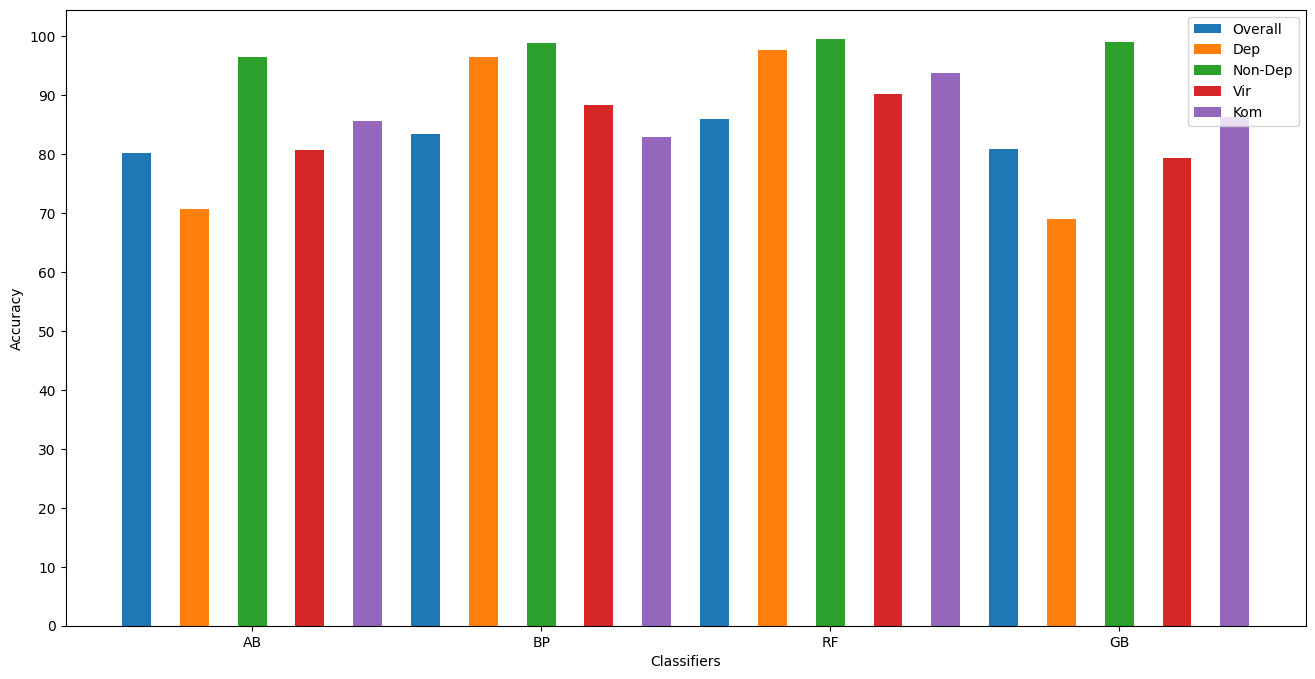

In [86]:
plt.figure(figsize=(16,8))
plt.bar(bar1, Ens_df['Acc'], label='Overall', align='edge', width=0.1)
plt.bar(bar2, Ens_df['Dep'], align='edge', width=0.1, label='Dep')
plt.bar(bar3, Ens_df['Non-Dep'], align='edge', width=0.1, label='Non-Dep')
plt.bar(bar4, Ens_df['Vir'], align='edge', width=0.1, label='Vir')
plt.bar(bar5, Ens_df['Kom'], align='edge', width=0.1, label='Kom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks(bar1+0.45, x)
plt.yticks(np.arange(0, 101, 10))
plt.legend(loc='upper right')
plt.show()